In [50]:
#!/usr/bin/env python
# coding: utf-8

# In[90]:


#!/usr/bin/env python
# coding: utf-8

# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Functipn to split data into training, validation and test sets
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import glob   # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched.
import os   # miscellneous operating system interfaces. This module provides a portable way of using operating system dependent functionality. If you just want to read or write a file see open(), if you want to manipulate paths, see the os.path module, and if you want to read all the lines in all the files on the command line see the fileinput module.
import random       
from tqdm import tqdm 
from tqdm.notebook import tqdm_notebook
import datetime
import time
from tabulate import tabulate
import math 

import umap
import math


# Torch
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn


from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve,log_loss, accuracy_score, f1_score
from sklearn.metrics import average_precision_score,roc_auc_score
from sklearn.ensemble import VotingClassifier
import os
import time
from time import time
import datetime
import pandas as pd
import numpy as np
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.adapt import MLkNN

# CMAP (extracting relevant transcriptomic profiles)
from cmapPy.pandasGEXpress.parse import parse
import cmapPy.pandasGEXpress.subset_gctoo as sg
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import joblib

from sklearn.decomposition import PCA,FactorAnalysis
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.metrics import precision_recall_curve,log_loss
from sklearn.metrics import average_precision_score,roc_auc_score
from sklearn.feature_selection import VarianceThreshold
import os
import pandas as pd
import numpy as np
import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
nn._estimator_type = "classifier"

# -------------------------------------------------------------------------------------------------------------------------# 
# Prepping Neptune.ai for logging --------------------------------------------------------------------------------------------
import neptune.new as neptune


# Downloading all relevant data frames and csv files ----------------------------------------------------------

# clue column metadata with columns representing compounds in common with SPECs 1 & 2
clue_sig_in_SPECS = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_sig_in_SPECS1&2.csv', delimiter = ",")

# clue row metadata with rows representing transcription levels of specific genes
clue_gene = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_geneinfo_beta.txt', delimiter = "\t")

# -------------------------------------------------------------------------------------------------------------------------
def load_train_valid_data(train_data, valid_data):
    '''
    Functions loads the data frames that will be used to train classifier and assess its accuracy in predicting.
    input:
        train_data: filename of training csv file
        valid_data: filename of validation csv file
    ouput:
       L1000 training: pandas dataframe with training data
       L1000 validation: pandas dataframe with validation data
    '''
    path = '/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/data_split_csvs/'
    L1000_training = pd.read_csv(path + train_data, delimiter = ",")
    L1000_validation =pd.read_csv(path + valid_data, delimiter = ",")
    return L1000_training, L1000_validation

def variance_threshold(x_train, x_val):
    """
    This function perform feature selection on the data, i.e. removes all low-variance features below the
    given 'threshold' parameter.
    
    Args:
            x_fold_train: K-fold train data with only phenotypic/morphological features and PCs - pandas 
            dataframe.
            x_fold_val: K-fold validation data with only phenotypic/morphological features and PCs - pandas 
            dataframe.
            df_test_x_copy: test data - pandas dataframe with only phenotypic/morphological features and PCs.
    
    Returns:
            x_fold_train: K-fold train data after feature selection - pandas dataframe.
            x_fold_val: K-fold validation data after feature selection - pandas dataframe.
            df_test_x_copy: test data - pandas dataframe after feature selection - pandas dataframe.
    
    inspired by https://github.com/broadinstitute/lincs-profiling-complementarity/tree/master/2.MOA-prediction
    
    """
    var_thresh = VarianceThreshold(threshold = 0.8) # sets a variance threshold
    var_thresh.fit(x_train) # learn empirical variances from X
    x_train = x_train.loc[:,var_thresh.variances_ > 0.8] # locate all variance thresholds above 0.8, keep those columns
    x_val = x_val.loc[:,var_thresh.variances_ > 0.8]
    return x_train, x_val

def normalize_func(trn, test):
    """
    Performs quantile normalization on the train, test and validation data. The QuantileTransformer
    is fitted on the train data, and transformed on test and validation data.
    
    Args:
            trn: train data - pandas dataframe.
            val: validation data - pandas dataframe.
            test: test data - pandas dataframe.
    
    Returns:
            trn_norm: normalized train data - pandas dataframe.
            val_norm: normalized validation - pandas dataframe.
            test_norm: normalized test data - pandas dataframe.
    inspired by  https://github.com/broadinstitute/lincs-profiling-complementarity/tree/master/2.MOA-prediction
    """
    norm_model = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    # norm_model = StandardScaler()
    trn_norm = pd.DataFrame(norm_model.fit_transform(trn),index = trn.index,columns = trn.columns)
    tst_norm = pd.DataFrame(norm_model.transform(test),index = test.index,columns = test.columns)
    return trn_norm, tst_norm


def tprofiles_gc_too_func(data, clue_gene):
    '''
    Function preparing the gctoo dataframe to extract from gctx file, choosing only landmark genes
    
    Input:
    data: column meta data from clue.io that only includes training/test data
    clue_gene: row meta data from clue.io transcriptomic profiles
    
    Output:
    parsed gctoo file with all of the transcriptomic profiles. Only landmark genes included.'''

    clue_gene["gene_id"] = clue_gene["gene_id"].astype(str)
    landmark_gene_row_ids = clue_gene["gene_id"][clue_gene["feature_space"] == "landmark"]

    # get all samples (across all cell types, doses, and other treatment conditions) with certain MoA
    profile_ids = data["sig_id"]
    tprofiles_gctoo = parse("/scratch2-shared/erikep/level5_beta_trt_cp_n720216x12328.gctx", 
                                    cid= profile_ids, 
                                    rid = landmark_gene_row_ids)

    return tprofiles_gctoo

def extract_tprofile(profiles_gc_too, idx):
    '''returns transcriptomic profile of of specific ID with in the form of a numpy array
    
    input:
     profiles_gc_too: gc_too dataframe hosting transcriptomic profiles
     idx:  extract unique column name from L1000 data
    
    output: 
      numpy array of a single transcriptomic profile
    '''
    tprofile_id =  profiles_gc_too.col_metadata_df.iloc[idx]
    tprofile_id_sig = [tprofile_id.name] 
    tprofile_gctoo = sg.subset_gctoo(profiles_gc_too, cid= tprofile_id_sig) 
    #return torch.tensor(tprofile_gctoo.data_df.values.astype(np.float32)) 
    return tprofile_id_sig, np.asarray(tprofile_gctoo.data_df.values.astype(np.float32))    


def splitting(df):
    '''Splitting data into two parts:
    1. input : the pointer showing where the transcriptomic profile is  
    2. target : labels (the correct MoA)
    
    Input:
        df: pandas dataframe with all columns.
    Output:
      input: pandas dataframe with all of the features
      target : returns the MoA class column separately, and as a string 
      '''
    
    target = df['moa']
    target = target.apply(str)
    input =  df.drop('moa', axis = 1)
    
    return input, target


def np_array_transform(profiles_gc_too):
    '''
    Takes a .gctoo and extracts the correct profile, transforms the profile into a numpy array and then places it into a pandas data_frame.

    Input:
        profiles_gc_too: the gc_too dataframe with all the transcriptomic profiles

    Output:
        df: pandas dataframe, where each row is a transcriptomic profile
    '''
    rows = []
    sig_id_check = []
    for i in range(profiles_gc_too.data_df.shape[1]):
        sig_id_row, np_array = extract_tprofile(profiles_gc_too, i)
        rows.append(np_array)
        sig_id_check.append(sig_id_row)
    np_array =  np.asarray(rows)
    np_array = np_array.squeeze()
    df = pd.DataFrame(np_array)
    sig_id_df = pd.DataFrame(sig_id_check)
    df["sig_id"] =  sig_id_df[0:]
    return df

def acquire_npy(dataset):
    '''
    Acquiring the numpy dataset in the npy format if it has already been created. Purpose is to save the reloading of the .npy dataframe, which can take 
    up to 9 minutes for the 10 MoAs.

    Input: 
    String with either "train" or "val". Then the user than manually inputs the name of the file.

    Ouput:
    Returns pandas dataframe from the .npy file found in '/scratch2-shared' given by the user.
    '''
    path = '/scratch2-shared/erikep/data_splits_npy'
    if dataset == 'train':
        #filename = input('Give name of npy file (str): ')
        #npy_set = np.load(path + filename)
        npy_set = np.load('/scratch2-shared/erikep/data_splits_npy/data_splits_npy2_moas_train.npy')
    elif dataset == 'val':
        #filename = input('Give name of npy file (str): ')
        #npy_set = np.load(path + filename)
        npy_set = np.load('/scratch2-shared/erikep/data_splits_npy/data_splits_npy2_moas_valid.npy')
    else:
        filename =  input('Give name of npy file (str): ')
        npy_set = np.load(path + filename)
    return pd.DataFrame(npy_set)

def save_npy(dataset):
    '''Save the numpy array of the selected transcriptomics profiles
    Input:
        dataset: the numpy array to be saved
    '''
    path = '/scratch2-shared/erikep/data_splits_npy/'
    file_name = input("Give filename for numpy array: ")
    np.save(path + file_name, dataset)

def get_models(class_weight):
    '''
    Input:
        class weight: including or not including class weight.
    Output:
        A list of tuples, with a str with a descriptor followed by the classifier function)
    '''
    TNC = TabNetClassifier()
    TNC._estimator_type = "classifier"
    models = list()
    models.append(('logreg', LogisticRegression(class_weight = class_weight, solver= "liblinear", penalty = "l2"))) 
    #models.append(('RFC',RandomForestClassifier(class_weight= class_weight))) 
    #models.append(('gradboost', GradientBoostingClassifier()))
    #models.append(('Ada', AdaBoostClassifier()))
    #models.append(('KNN', KNeighborsClassifier(n_neighbors = 5)))
    #models.append(('Bagg',BaggingClassifier()))
    #models.append(('Tab', TNC))
    return models

def printing_results(class_alg, labels_val, predictions): 
    '''
    Printing the results from the 
    Input:
        class_alg: name of the model
        labels_val: the correct guesses
        predictions: the predictions made by the model
    Output:
        Printed results of accuracy, F1 score, and confusion matrix
    '''
    print('----------------------------------------------------------------------')
    print(class_alg)
    anders = f1_score(labels_val, predictions, labels = ["0","1"], average = 'macro')
    print(f' Accuracy score: {accuracy_score(labels_val, predictions)}')
    print(f' F1 Score: {     anders   }')
    print(f' Confusion Matrix: {confusion_matrix(labels_val, predictions)}')
    print('----------------------------------------------------------------------')

def write_list(a_list, file_type):
    with open('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/pickles/tabnet_pickles/' + file_type + '.pickle', 'wb') as fp:
        pickle.dump(a_list, fp)
    print('Done writing binary file')

def save_val(a_list, file_type):
    with open('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/pickles/val_order_pickles/' + file_type + '.pickle', 'wb') as fp:
        pickle.dump(a_list, fp)
    print('Done writing binary file')

# ------------------------------------------------------------------------------------------------------------------------------
def main(use_variance_threshold, normalize, L1000_training, L1000_validation, clue_gene, npy_exists, apply_class_weight, ensemble):
    '''
    Tests a series of ML algorithms after optional pre-processing of the data in order to make predictions on the MoA class based on
    chosen transcriptomic profiles. 

    Input:
        use_variance_threshold: True/False (also have to adjust hyperparameter in the function itself depending on normalization.)
        normalize: True/False. Whether or not to normalize the data.
        L1000_training: Str. Name of the csv file with training rows
        L1000_validation: Str. Name of the csv file with validation rows
        clue_gene: Row metadata fro the transcriptomic profiles
        npy_exists: True/False: whether or not the numpy array with transcriptomic profiles has already been created (can save time if many moas are used.)
        apply_class_weight: True/False. Whether to apply class weights for the random forest classifier.
        ensemble: True/False. Whether to apply to do an ensemble classifier with a select number of classifiers.
    Output:
        Prints the accuracy, F1 score and confusion matrix for each of the ML algorithms.
        Save unique numpy array. 
    '''
    # shuffling training and validation data
    L1000_training = L1000_training.sample(frac = 1, random_state = 1)
    L1000_validation = L1000_validation.sample(frac = 1, random_state = 1)
    # extracting training transcriptomes
    profiles_gc_too_train = tprofiles_gc_too_func(L1000_training, clue_gene)
    if npy_exists:
        df_train = acquire_npy('train')
    else:    
        df_train = np_array_transform(profiles_gc_too_train)
        #save_npy(df_train)
    
    #input_df_train, labels_train = splitting(L1000_training) 
    #print(sig_id_df_check.head(20))
    #print(input_df_train.sig_id.head(20))
    #assert sig_id_df_check.all() == input_df_train.sig_id.all()
    
    # create dictionary where moas are associated with a number

   
    # extracting valid 
    profiles_gc_too_valid = tprofiles_gc_too_func(L1000_validation, clue_gene)
    if npy_exists:
        df_val = acquire_npy('val')
    else:    
        df_val = np_array_transform(profiles_gc_too_valid)
       
    '''
    # to normalize
    if normalize:
        df_train, df_val = normalize_func(df_train, df_val)
    
    # applying class weights
    if apply_class_weight:
        class_weight = "balanced"
    else:
        class_weight = None
    
    models = get_models(class_weight)
    scores = list()
    # battery of classifiers
    for class_alg in models:
        classifier = class_alg[1]
        # use variance threshold
        if use_variance_threshold:
            df_train_vs, df_val_vs = variance_threshold(df_train, df_val)
            classifier.fit(df_train_vs.values, labels_train.values)
            predictions = classifier.predict(df_val_vs.values)
            if class_alg[0] == 'Tab':
                save_val(labels_val, 'tab_val')
                class_probs= classifier.predict_proba(df_val_vs.values)
                write_list(predictions, 'predictions')
                write_list(class_probs, 'class_probs')

        else:
            classifier.fit(df_train.values, labels_train.values)
            predictions = classifier.predict(df_val.values)
            if class_alg[0] == 'Tab':
                save_val(labels_val, 'tab_val')
                class_probs = classifier.predict_proba(df_val_vs.values)
                write_list(predictions, 'predictions')
                write_list(class_probs, 'class_probs')
        f1_score_from_model = f1_score(labels_val, predictions, average= "macro") 
        scores.append(f1_score_from_model)
        printing_results(class_alg, labels_val, predictions)
       


    if ensemble:
        # 'soft':  predict the class labels based on the predicted probabilities p for classifier 
        ensemble = VotingClassifier(estimators = models, voting = 'soft', weights = scores)
        
        if use_variance_threshold:
                df_train_vs, df_val_vs = variance_threshold(df_train, df_val)
                ensemble.fit(df_train_vs.values, labels_train.values)
                predictions = ensemble.predict(df_val_vs.values)

        else:
            ensemble.fit(df_train.values, labels_train.values)
            predictions = ensemble.predict(df_val.values)
        
        printing_results('ensemble', labels_val, predictions)'''
    return df_train, df_val


# In[91]:


if __name__ == "__main__":  
    # train_filename = input('Training Data Set Filename: ')
    #valid_filename = input('Validation Data Set Filename: ')
    #train_filename = 'L1000_training_set_cyclo_adr_2.csv'
    #valid_filename = 'L1000_test_set_cyclo_adr_2.csv'
    train_filename = 'L1000_training_set_nv_cyc_adr.csv'
    valid_filename = 'L1000_test_set_nv_cyc_adr.csv'
    #train_filename = 'L1000_training_set.csv'
    # valid_filename = 'L1000_valid_set.csv'
    
    # loading data
    L1000_training, L1000_validation =  load_train_valid_data(train_filename, valid_filename)
    df_train, df_val = main(use_variance_threshold = False, 
         normalize= True, 
         L1000_training = L1000_training, 
         L1000_validation = L1000_validation, 
         clue_gene= clue_gene, 
         npy_exists = False,
         apply_class_weight= True,
         ensemble = False)



moa_dictionary = {}
for i,j in enumerate(L1000_training.moa.unique()):
    moa_dictionary[j] = i

# merging the transcriptomic profiles with the corresponding MoA class using the sig_id as a key
df_train = pd.merge(df_train, L1000_training[["sig_id", "moa"]], how = "outer", on ="sig_id")
df_val = pd.merge(df_val, L1000_validation[["sig_id", "moa"]], how = "outer", on ="sig_id")
# dropping the sig_id column
df_train.drop(columns = ["sig_id"], inplace = True)
df_val.drop(columns = ["sig_id"], inplace = True)
    # separating the features from the labels
df_train_features = df_train[df_train.columns[: -1]]
df_val_features = df_val[df_val.columns[: -1]]
df_train_labels = df_train["moa"]
df_val_labels = df_val["moa"]


In [7]:
df_train_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,968,969,970,971,972,973,974,975,976,977
0,1.7527,0.0000,-0.8541,-0.8805,-0.2432,0.5100,-0.2179,0.3331,-0.6835,0.3024,...,-0.3588,-0.5946,1.0200,-0.6292,-0.6189,0.2204,-0.2688,0.7418,-0.2002,0.9993
1,2.0940,0.7389,-0.7892,-0.4282,0.7571,1.4361,-0.5794,-1.0546,-2.0860,-0.8119,...,-0.8565,-2.2017,0.2389,-0.4334,-0.6115,-0.1084,-1.3946,0.4816,0.7590,-0.5188
2,0.8020,-0.2042,-1.3469,-0.0297,-0.9953,-4.4048,-1.9684,0.4010,-2.0086,1.2412,...,-1.3844,-0.8989,-1.0123,0.2576,0.1446,0.0000,0.4691,-0.0898,0.6745,0.1521


In [67]:
df_train_labels

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2902    0.0
2903    1.0
2904    1.0
2905    1.0
2906    0.0
Name: moa, Length: 2907, dtype: float64

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
def dict_splitting_into_tensor(df):
    '''Splitting data into two parts:
    1. input : the pointer showing where the transcriptomic profile is  
    2. target one hot : labels (the correct MoA) '''
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df["moa"].unique().reshape(-1,1))
    one_hot_encoded = enc.transform(enc.categories_[0].reshape(-1,1)).toarray()
    dicti = {}
    for i in range(0, len(enc.categories_[0])):
        dicti[str(enc.categories_[0][i])] = one_hot_encoded[i]
    return dicti

In [20]:
moa_dict = dict_splitting_into_tensor(L1000_training)

In [56]:
moa_dict['cyclooxygenase inhibitor'] = 1.0
moa_dict['dopamine receptor antagonist'] = 0.0


In [57]:
moa_dict

{'cyclooxygenase inhibitor': 1.0,
 'dopamine receptor antagonist': 0.0,
 'adrenergic receptor antagonist': 0.0}

In [60]:
df_train_labels= df_train_labels.replace(moa_dict)
df_val_labels= df_val_labels.replace(moa_dict)

In [68]:
df_train_labels

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2902    0.0
2903    1.0
2904    1.0
2905    1.0
2906    0.0
Name: moa, Length: 2907, dtype: float64

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from umap import UMAP

In [63]:
svc = LinearSVC(dual=False, random_state=123)
log_reg = LogisticRegression(random_state=123)

In [64]:
# Transformation with UMAP followed by classification with a linear SVM
umap = UMAP(random_state=456)
pipeline = Pipeline([("umap", umap), ("logreg", log_reg)])
params_grid_pipeline = {
    "umap__n_neighbors": [5, 20]
    #"umap__n_components": [15, 25, 50]
    #"svc__C": [10 ** k for k in range(-3, 4)],
}


clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
clf_pipeline.fit(df_train_features.values, df_train_labels.values)
print("Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(df_val_features.values, df_val_labels.values)))

Accuracy on the test set with UMAP transformation: 0.504


In [65]:
clf_pipeline.best_params_

{'umap__n_neighbors': 20}

In [ ]:

run = neptune.init_run(project='erik-everett-palm/Tomics-PCA-UMAP')
run["parameters/moa_dictionary"] = str(moa_dictionary)
run["parameters/train_filename"] = train_filename
norm = False
if norm:
    scaler = StandardScaler()
    df_train[df_train.columns[:-1]] = StandardScaler().fit_transform(df_train[df_train.columns[:-1]])
    run["parameters/normalize"] = str(scaler)
else:
    run["parameters/normalize"] = "None"
    
df_train = pd.merge(df_train, L1000_training[["sig_id", "moa"]], how = "outer", on ="sig_id")




df_train.drop(columns = ["sig_id"], inplace = True)


Testing Optuna for hyperparameter optimization

In [78]:
import optuna
def objective(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    classifier = LogisticRegression(solver=solver, penalty=penalty, class_weight=class_weight)
    classifier.fit(df_train_features.values, df_train_labels.values)
    predictions = classifier.predict(df_val_features.values)
    return f1_score(df_val_labels, predictions, average= "macro")

In [ ]:
# Transformation with UMAP followed by classification with a linear SVM
umap = UMAP(random_state=456)
pipeline = Pipeline([("umap", umap), ("logreg", log_reg)])
params_grid_pipeline = {
    "umap__n_neighbors": [5, 20]
    #"umap__n_components": [15, 25, 50]
    #"svc__C": [10 ** k for k in range(-3, 4)],
}


clf_pipeline = GridSearchCV(pipeline, params_grid_pipeline)
clf_pipeline.fit(df_train_features.values, df_train_labels.values)
print("Accuracy on the test set with UMAP transformation: {:.3f}".format(
        clf_pipeline.score(df_val_features.values, df_val_labels.values)))

In [79]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-02-17 16:33:48,198] A new study created in memory with name: no-name-cba9d3ee-7324-452b-ab92-41c5b67a3a81
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-02-17 16:33:50,074] Trial 0 finished with value: 0.7264626442118158 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7264626442118158.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACH

In [80]:
study.best_params

{'solver': 'saga', 'penalty': 'l2', 'class_weight': 'balanced'}

In [84]:
import optuna
from sklearn.linear_model import RidgeClassifierCV
def objective2(trial):
    alphas = trial.suggest_float('alpha', 0.1, 15)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    classifier = RidgeClassifierCV(alphas = alphas, class_weight= class_weight)
    classifier.fit(df_train_features.values, df_train_labels.values)
    predictions = classifier.predict(df_val_features.values)
    return f1_score(df_val_labels, predictions, average= "macro")

In [85]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective2, n_trials=25)

[I 2023-02-17 16:49:52,181] A new study created in memory with name: no-name-39ccf96e-24a8-48d0-b3d7-a53678297607
[I 2023-02-17 16:50:05,981] Trial 0 finished with value: 0.7226627280265341 and parameters: {'alpha': 14.9246610880335, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7226627280265341.
[I 2023-02-17 16:50:23,375] Trial 1 finished with value: 0.691077990817729 and parameters: {'alpha': 1.910641794240239, 'class_weight': None}. Best is trial 0 with value: 0.7226627280265341.
[I 2023-02-17 16:50:43,782] Trial 2 finished with value: 0.6873104367472327 and parameters: {'alpha': 8.564382170097081, 'class_weight': None}. Best is trial 0 with value: 0.7226627280265341.
[I 2023-02-17 16:50:54,675] Trial 3 finished with value: 0.6891956891956892 and parameters: {'alpha': 6.993518117301544, 'class_weight': None}. Best is trial 0 with value: 0.7226627280265341.
[I 2023-02-17 16:51:08,983] Trial 4 finished with value: 0.7172957655250587 and parameters: {'alpha': 4.1295983643

In [ ]:
import optuna
from sklearn.linear_model import LinearDiscriminantAnalysis
def objective3(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    classifier = LogisticRegression(solver=solver, penalty=penalty, class_weight=class_weight)
    classifier.fit(df_train_features.values, df_train_labels.values)
    predictions = classifier.predict(df_val_features.values)
    return f1_score(df_val_labels, predictions, average= "macro")

study3 = optuna.create_study(direction='maximize')
study3.optimize(objective3, n_trials=100)

In [35]:
import cv2
 
# read an image
img = cv2.imread("/scratch2-shared/erikep/Results/Test_2/data/_11656_image.png")

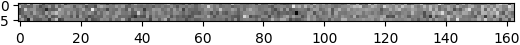

In [40]:
from IPython.display import Image
Image(filename="/scratch2-shared/erikep/Results/Test_1/data/_11656_image.png") 

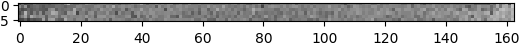

In [41]:
Image(filename="/scratch2-shared/erikep/Results/Test_1/data/_200_image.png") 

In [34]:
assert img.all() == img2.all(), ("bro, the fuck")
